In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import pandas as pd
import datetime as dt
import numpy_financial as npf
import yfinance as yf
from scipy.optimize import minimize

plt.style.use("ggplot")
import statsmodels.api as sm
from yahoo_fin import stock_info as si

import fin_func as ff

## <font face="gotham" color="purple"> Capital Assets Pricing Model</font>

Unsystematic risks can be diversified. Systematic risks can't be diversified, $\text{CAPM}$ measures this risk with $\beta$.

$$
\begin{aligned}
E(R_i)= & R_f+\beta_i[E(R_m)-R_f]
\end{aligned}
$$
\begin{array}{ll}
E\left(R_i\right) & =\text { capital asset expected return, e.g. a single stock or a portfolio } \\
R_f & =\text { risk-free return, e.g. 10y treasury bond} \\
\beta_i & =\text { sensitivity } \\
E\left(R_m\right) & =\text { expected return of the market, e.g. S&P500 }
\end{array}

$\beta_i$ can be calculated by OLS formula, i.e.
$$
\beta= \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$
it tells how risky your portfolio is relative to the market, it only measures the systematic risk. 

The portfolio $\beta$ will be a weighted $\beta$ 
$$
\beta = \sum_{i=1}^n w_i\beta_i
$$

The model can be rewritten as 
\begin{aligned}
E(R_i)-R_f= \alpha_i+\beta_i[E(R_m)-R_f]
\end{aligned}
to explicitly estimate $\alpha$ as a constant. It characterizes the excess rate of return that

$$
\alpha_i= E(R_i)-\{R_f+\beta_i[E(R_m)-R_f]\}
$$
Usually the classic CAPM assumes $\alpha=0$

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
In short, $\beta$ measures systematic risks, $\alpha$ measure excess returns.
</div> 

## <font face="gotham" color="purple"> Implementation of CAPM</font>

1.2567699380080932


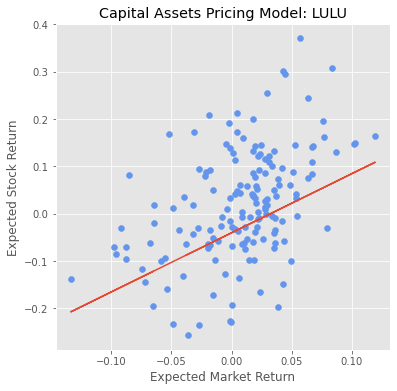

alpha: 0.022027169160354493
beta: 1.2487137204567593


In [12]:
class CAPM:
    def __init__(self, stocks, start_date, end_date):
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        stock_data = {}
        for stock in self.stocks:
            ticker = yf.Ticker(stock)
            stock_data[stock] = ticker.history(
                start=self.start_date, end=self.end_date
            )["Close"]
        return pd.DataFrame(stock_data)

    def resample_month(self):
        # montly return gives a better normally distributed results
        stock_data = (
            self.download_data()
        )  # without this, 'stock_data' will be called before assignment
        stock_data = stock_data.resample("M").last()
        self.data = pd.DataFrame(
            {
                "s_adjclose": stock_data[self.stocks[0]],
                "m_adjclose": stock_data[self.stocks[1]],
            }
        )
        self.data[["s_logreturn", "m_logreturn"]] = np.log(self.data) - np.log(
            self.data.shift()
        )
        self.data = self.data.dropna()
        return self.data

    def calculate_beta(self):
        cov_matrix = np.cov(self.data["s_logreturn"], self.data["m_logreturn"])
        self.beta = cov_matrix[0, 1] / np.var(self.data["m_logreturn"])
        print(self.beta)
        return self.beta

    def lin_reg(self):
        R_F = 0.05
        month_in_year = 12

        X = self.data["m_logreturn"] - R_F
        Y = self.data["s_logreturn"] - R_F
        X = sm.add_constant(X)  # adding a constant
        self.results = sm.OLS(Y, X).fit()
        alpha, beta = self.results.params[0], self.results.params[1]
        expected_return = R_F + beta * (
            self.data["m_logreturn"].mean() * month_in_year - R_F
        )
        self.plot_regression()
        print("alpha: {}".format(alpha))
        print("beta: {}".format(beta))
        return alpha, beta, expected_return

    def plot_regression(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(
            self.data["m_logreturn"], self.data["s_logreturn"], c="CornflowerBlue"
        )
        ax.plot(self.data["m_logreturn"], self.results.fittedvalues)
        ax.set_title("Capital Assets Pricing Model: {}".format(stocks[0]))
        ax.set_ylabel("Expected Stock Return")
        ax.set_xlabel("Expected Market Return")
        plt.show()


if __name__ == "__main__":
    stocks = ["LULU", "^GSPC"]
    capm = CAPM(stocks, start_date="2010-01-01", end_date=dt.datetime.today())
    data = capm.download_data()
    data_month = capm.resample_month()
    beta_calculated = capm.calculate_beta()
    alpha, beta, exp_ret = capm.lin_reg()

In [18]:
df1 = pd.DataFrame(si.tickers_sp500())
df2 = pd.DataFrame(si.tickers_nasdaq())
df3 = pd.DataFrame(si.tickers_dow())
df4 = pd.DataFrame(si.tickers_other())

In [19]:
sym1 = set(symbol for symbol in df1[0].values.tolist())
sym2 = set(symbol for symbol in df2[0].values.tolist())
sym3 = set(symbol for symbol in df3[0].values.tolist())
sym4 = set(symbol for symbol in df4[0].values.tolist())

In [24]:
symbols = set.union(sym1, sym2, sym3, sym4)

In [25]:
my_list = ["W", "R", "P", "Q"]
del_set = set()
sav_set = set()

In [26]:
for symbol in symbols:
    if len(symbol) > 4 and symbol[-1] in my_list:
        del_set.add(symbol)
    else:
        sav_set.add(symbol)